In [1]:
import time

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tritonclient.grpc as grpcclient


def plot(src, cmap=None, title=None, size=(10, 10)):
    %matplotlib inline
    plt.rcParams['figure.figsize'] = size
    plt.imshow(src, cmap)
    plt.title(title)

In [2]:
triton_url = "10.10.66.25:8001"

client = grpcclient.InferenceServerClient(url=triton_url, verbose=True)

### Read image

(720, 1280, 3)


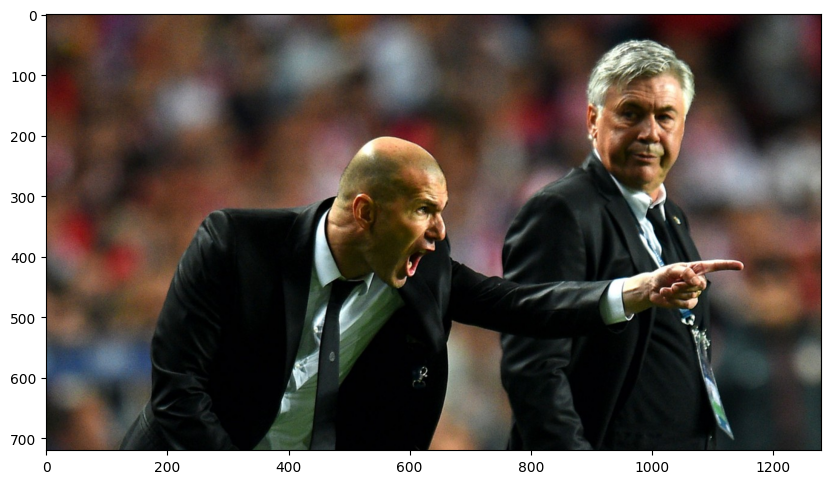

In [3]:
img = cv2.imread('zidane.jpg')[:,:,::-1]
print(img.shape)

plot(img)

In [4]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=False, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)


def batch_preprocessing(img_list: list) -> np.ndarray:
    batch = []
    
    for img in img_list:
        img = letterbox(img)[0]
        img = img.astype(np.float32)
        img = img.transpose(2, 0, 1)
        img /= 255
        batch.append(img)
    return np.array(batch)

In [5]:
batch = batch_preprocessing([img])
print(batch.shape)

inputs = []
inputs.append(grpcclient.InferInput("images", batch.shape, "FP32"))
inputs[0].set_data_from_numpy(batch)

outputs = []
outputs.append(grpcclient.InferRequestedOutput("output"))

(1, 3, 640, 640)


In [9]:
st_time = time.time()

results = client.infer("yolov5s_onnx", inputs, outputs=outputs)

finish_time = time.time()

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
print(f"Request took {round(finish_time-st_time, 3)}")

Request took 0.123


In [11]:
results.as_numpy("output").shape

(1, 25200, 85)

### Post processing

In [12]:
inputs = []
inputs.append(grpcclient.InferInput("output0", results.as_numpy("output").shape, "FP32"))
inputs[0].set_data_from_numpy(results.as_numpy("output"))

outputs = []
outputs.append(grpcclient.InferRequestedOutput("output_post"))

In [14]:
results = client.infer("yolov5s_post", inputs, outputs=outputs)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [15]:
results.as_numpy("output_post").shape

(1, 2, 6)

In [16]:
results.as_numpy("output_post")

array([[[371.45355  , 163.98683  , 570.5675   , 498.42896  ,
           0.8806373,   0.       ],
        [ 62.614044 , 236.80548  , 355.4504   , 496.54016  ,
           0.6413835,   0.       ]]], dtype=float32)

### Plot detection results

In [17]:
det_results = results.as_numpy("output_post")

for frame, frame_res in zip([img], det_results):
    img1 = letterbox(frame.copy())[0]
#     img1 = cv2.resize(img1, (640, 640))

    if frame_res.any():
        for i, res in enumerate(frame_res):
            x1, y1 = int(res[0]), int(res[1])
            x2, y2 = int(res[2]), int(res[3])

            label = f"person_{i}, conf={round(res[4], 3)}"
            cv2.rectangle(img1, (x1, y1), (x2, y2), (0, 255, 0), 1)

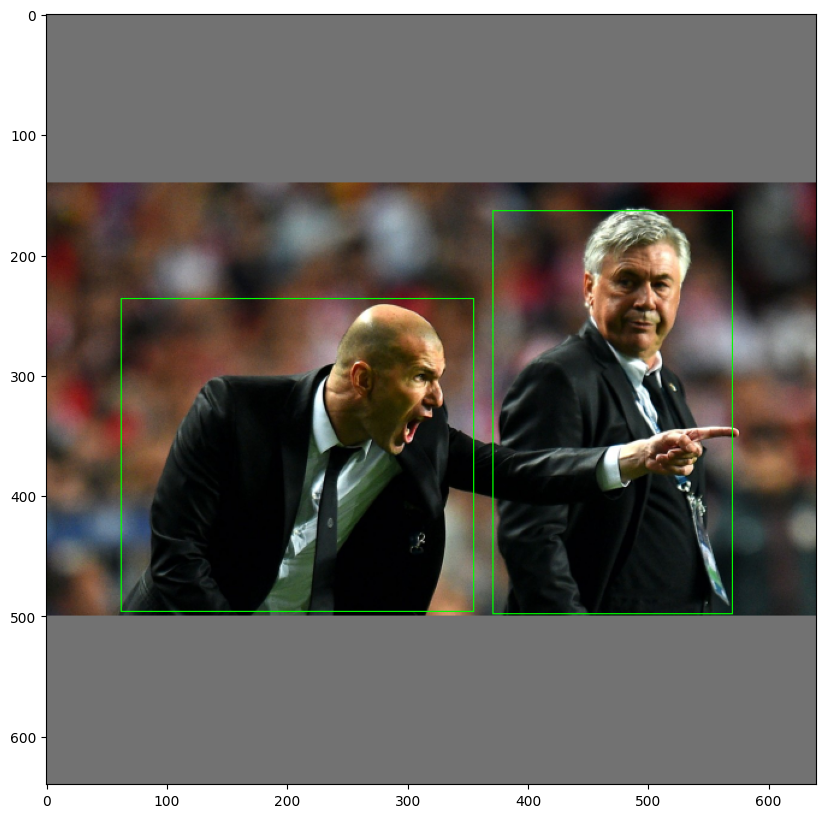

In [18]:
plot(img1)

### Pipe inference

In [19]:
img = cv2.imread('zidane.jpg')[:,:,::-1]

batch = batch_preprocessing([img])
print(batch.shape)

inputs = []
inputs.append(grpcclient.InferInput("images", batch.shape, "FP32"))
inputs[0].set_data_from_numpy(batch)

outputs = []
outputs.append(grpcclient.InferRequestedOutput("output_post"))

(1, 3, 640, 640)


In [25]:
st_time = time.time()

results = client.infer("yolov5s_pipe", inputs, outputs=outputs)

finish_time = time.time()

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [26]:
print(f"Request took {round(finish_time-st_time, 3)}")

Request took 0.042


In [29]:
det_results = results.as_numpy("output_post")

for frame, frame_res in zip([img], det_results):
    img1 = letterbox(frame.copy())[0]
#     img1 = cv2.resize(img1, (640, 640))

    if frame_res.any():
        for i, res in enumerate(frame_res):
            x1, y1 = int(res[0]), int(res[1])
            x2, y2 = int(res[2]), int(res[3])

            label = f"person_{i}, conf={round(res[4], 3)}"
            cv2.rectangle(img1, (x1, y1), (x2, y2), (0, 255, 0), 1)

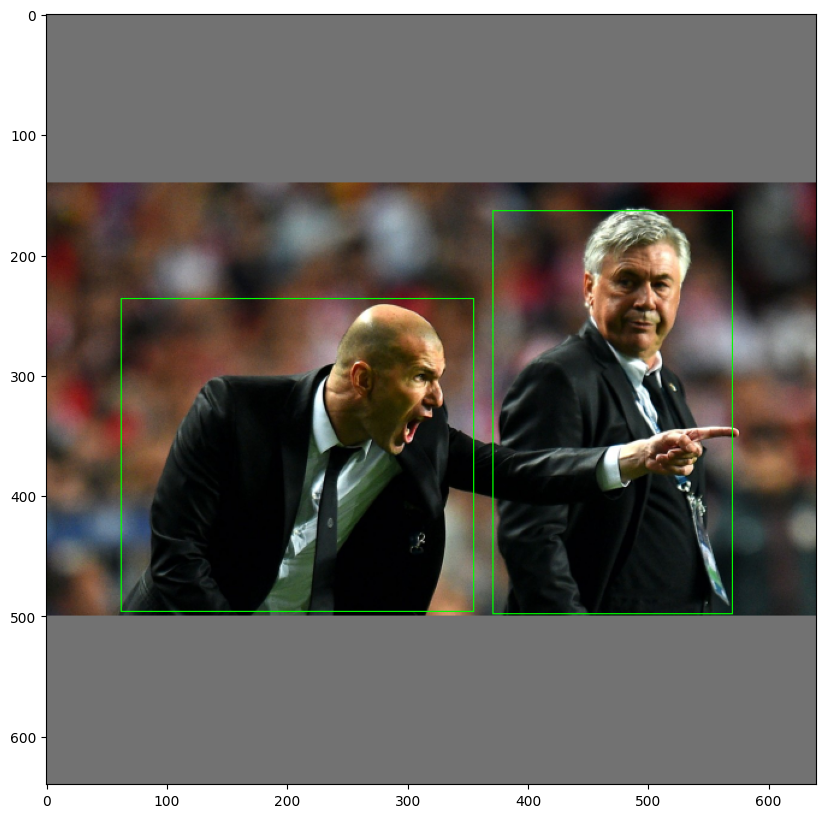

In [30]:
plot(img1)